In [6]:
import numpy as np
import tensorflow as tf

k = 3
n = 16
x_axis = [1, 2, 3, 4, 7, 8, 10, 13, 15, 16, 20, 31, 32]

In [17]:
import time
import functions

def full_tt(K1, K2, K3):
    """Converts a TensorTrain into a regular tensor or matrix (tf.Tensor)."""
    res = K1
    K2_reshaped = tf.reshape(K2, (K2.shape[0], -1))
    res = tf.matmul(res, K2_reshaped)
    res = tf.reshape(res, (-1, K3.shape[0]))
    res = tf.matmul(res, K3)
    res = tf.reshape(res, (K1.shape[0],) + K2.shape[1:-1] + (K3.shape[-1],))
    num_dims = len(K2.shape[1:-1])
    return tf.transpose(res, list(range(1, num_dims + 1)) + [0, num_dims + 1])

def get_new_K_time(K1, K2, K3, start):
    # (m, R) -> (m, min(m, R)) -- q: q.T @ q = I, (min(m, R), R) -- r
    next_t = time.time()
    print("Get new K begins", next_t - start)
    q1, r1 = tf.linalg.qr(K1, full_matrices=False)
    start = time.time()
    print("First QR", start - next_t)
    q3, r3 = tf.linalg.qr(tf.transpose(K3), full_matrices=False)
    next_t = time.time()
    print("Second QR", next_t - start)
    middle_k = full_tt(r1, K2, tf.transpose(r3))
    start = time.time()
    print("Full TT", start - next_t)
    return q1, middle_k, tf.transpose(q3)

def tensorflow_method64(kernel, n):
    conv_tr = tf.cast(tf.transpose(kernel, perm=[2, 3, 0, 1]), tf.complex64)
    transforms = tf.transpose(
        tf.signal.fft2d(
            tf.pad(
                conv_tr, ((0, 0), (0, 0), (0, n - kernel.shape[0]),
                                (0, n - kernel.shape[0]))
            )
        ), 
        perm=[2, 3, 0, 1]
    )
    return tf.linalg.svd(transforms, compute_uv=False)

def TT_method(kernel, n):
    K1, K2, K3 = functions.Clipping.get_new_K(kernel[0], kernel[1], kernel[2])
    return tensorflow_method64(K2, n)

def test_singular_method(filename, x_axis, k, n, method):
    m = 1000
    file_timestamps = open(filename, "w")
    file_timestamps.close()
    timestamps_means = []
    timestamps_vars = []
    for rank in x_axis:
        print("Starting with", rank)
        curr_times = []
        for i in range(100):
            kernel = [0] * 3
            rank = min(m, rank)
            kernel[0] = np.random.standard_normal(size=(m, rank))
            kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
            kernel[2] = np.random.standard_normal(size=(rank, m))
            start = time.time()
            s = TT_method(kernel, n)
            total = time.time() - start
            curr_times.append(total)
            if total >= 500:
                break
        curr_times = np.array(curr_times)
        curr_mean = curr_times.mean()
        curr_var = curr_times.var()
        file_timestamps = open(filename, "a")
        print(curr_mean, curr_var, file=file_timestamps)
        file_timestamps.close()
        timestamps_means.append(curr_mean)
        timestamps_vars.append(curr_var)
        print("Finishing with", rank)
        print("Mean time", timestamps_means[-1])
        if total >= 500:
            break
    return timestamps_means, timestamps_vars

In [1]:
from tensorflow.linalg import qr
import numpy as np
import time

In [131]:
m = 40
rank = 1
k = 3
kernel = [0] * 3
rank = min(m, rank)
for i in range(10):
    kernel[0] = np.random.standard_normal(size=(m, rank))
    kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
    kernel[2] = np.random.standard_normal(size=(rank, m))
    start = time.time()
    s = TT_method(kernel, 64)
    total = time.time() - start
    print(total)

0.013962745666503906
0.012001752853393555
0.010970354080200195
0.010972023010253906
0.010969877243041992
0.011969804763793945
0.007975101470947266
0.007932424545288086
0.00801539421081543
0.008978605270385742


In [130]:
m = 40
rank = 2
k = 3
kernel = [0] * 3
rank = min(m, rank)
for i in range(10):
    kernel[0] = np.random.standard_normal(size=(m, rank))
    kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
    kernel[2] = np.random.standard_normal(size=(rank, m))
    start = time.time()
    s = TT_method(kernel, 64)
    total = time.time() - start
    print(total)

0.010969877243041992
0.010973930358886719
0.009971141815185547
0.009970426559448242
0.009974241256713867
0.008977651596069336
0.00997304916381836
0.010961771011352539
0.009972333908081055
0.006980180740356445


In [50]:
kernel = [0] * 3
rank = min(m, rank)
kernel[0] = np.random.standard_normal(size=(m, rank))
kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
kernel[2] = np.random.standard_normal(size=(rank, m))
start = time.time()
s = TT_method(kernel, 64)
total = time.time() - start
total

0.011966228485107422

In [2]:
rank = 1
m = 40
K1 = np.random.standard_normal(size=(m, rank))
start = time.time()
q1, r1 = qr(K1, full_matrices=False)
print(time.time() - start)
start = time.time()
q1, r1 = qr(K1, full_matrices=False)
print(time.time() - start)

0.04288506507873535
0.0


In [3]:
rank = 1
m = 40
K1 = np.random.standard_normal(size=(m, rank))
start = time.time()
q1 = tf.linalg.svd(K1)
print(time.time() - start)
start = time.time()
q1 = tf.linalg.svd(K1)
print(time.time() - start)

0.033901214599609375
0.0


In [4]:
rank = 1
m = 40
K1 = np.random.standard_normal(size=(m, rank))
start = time.time()
q1 = tf.linalg.svd(K1)
print(time.time() - start)
start = time.time()
q1 = tf.linalg.svd(K1)
print(time.time() - start)

0.0
0.0


In [4]:
rank = 1
m = 40
K1 = np.random.standard_normal(size=(m, rank))
start = time.time()
q1, r1 = np.linalg.qr(K1)
print(time.time() - start)
start = time.time()
q1, r1 = np.linalg.qr(K1)
print(time.time() - start)

0.006020307540893555
0.0009622573852539062


In [6]:
rank = 1
m = 40
K1 = np.random.standard_normal(size=(m, rank))
start = time.time()
q1, r1 = np.linalg.qr(K1)
print(time.time() - start)
start = time.time()
q1, r1 = np.linalg.qr(K1)
print(time.time() - start)

0.0009975433349609375
0.0


In [9]:
a = time.time()
a

1622798559.3429875

In [4]:
kernel = [0] * 3
rank = 1
m = 40
kernel[0] = np.random.standard_normal(size=(m, rank))
kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
kernel[2] = np.random.standard_normal(size=(rank, m))
start = time.time()
s = TT_method_time(kernel, n, start)
total = time.time() - start
print(total)
start = time.time()
s = TT_method_time(kernel, n, start)
total = time.time() - start
print(total)

0.0
Get new K begins 0.0019941329956054688
First QR 0.06582307815551758
Second QR 0.0009968280792236328
Full TT 0.0029926300048828125
0.07280397415161133
0.074798583984375
0.0
Get new K begins 0.0
First QR 0.0
Second QR 0.0009970664978027344
Full TT 0.0019960403442382812
0.003991842269897461
0.0049877166748046875


In [5]:
kernel = [0] * 3
rank = 1
m = 40
kernel[0] = np.random.standard_normal(size=(m, rank))
kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
kernel[2] = np.random.standard_normal(size=(rank, m))
start = time.time()
s = TT_method(kernel, n)
total = time.time() - start
total

0.003989458084106445

In [5]:
kernel = [0] * 3
rank = 1
m = 40
kernel[0] = np.random.standard_normal(size=(m, rank))
kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
kernel[2] = np.random.standard_normal(size=(rank, m))
start = time.time()
s = TT_method(kernel, n)
total = time.time() - start
total

0.004986763000488281

In [3]:
timestamps_means_TT, timestamps_vars_TT = test_singular_method(
    "n = 16 TT_mean_var_rank.txt", x_axis, k, 16, TT_method)

Starting with 1
Finishing with 1
Mean time 0.1000653902689616
Starting with 2
Finishing with 2
Mean time 0.008309364318847656
Starting with 3
Finishing with 3
Mean time 0.003989219665527344
Starting with 4
Finishing with 4
Mean time 0.006316423416137695
Starting with 7
Finishing with 7
Mean time 0.008310874303181967
Starting with 8
Finishing with 8
Mean time 0.009307384490966797
Starting with 10
Finishing with 10
Mean time 0.015291531880696615
Starting with 13
Finishing with 13
Mean time 0.030584335327148438
Starting with 15
Finishing with 15
Mean time 0.04654177029927572
Starting with 16
Finishing with 16
Mean time 0.022938251495361328
Starting with 20
Finishing with 20
Mean time 0.02627388636271159
Starting with 31
Finishing with 31
Mean time 0.06515868504842122
Starting with 32
Finishing with 32
Mean time 0.05956427256266276


In [4]:
timestamps_means_TT, timestamps_vars_TT = test_singular_method(
    "n = 32 TT_mean_var_rank.txt", x_axis, k, 32, TT_method)

Starting with 1
Finishing with 1
Mean time 0.0046541690826416016
Starting with 2
Finishing with 2
Mean time 0.004654248555501302
Starting with 3
Finishing with 3
Mean time 0.004985332489013672
Starting with 4
Finishing with 4
Mean time 0.0074702103932698565
Starting with 7
Finishing with 7
Mean time 0.02012976010640462
Starting with 8
Finishing with 8
Mean time 0.028410832087198894
Starting with 10
Finishing with 10
Mean time 0.0482033888498942
Starting with 13
Finishing with 13
Mean time 0.09436853726704915
Starting with 15
Finishing with 15
Mean time 0.13766853014628092
Starting with 16
Finishing with 16
Mean time 0.06044212977091471
Starting with 20
Finishing with 20
Mean time 0.10106309254964192
Starting with 31
Finishing with 31
Mean time 0.2516581217447917
Starting with 32
Finishing with 32
Mean time 0.2962074279785156


In [5]:
timestamps_means_TT, timestamps_vars_TT = test_singular_method(
    "n = 64 TT_mean_var_rank.txt", x_axis, k, 64, TT_method)

Starting with 1
Finishing with 1
Mean time 0.011635700861612955
Starting with 2
Finishing with 2
Mean time 0.008310874303181967
Starting with 3
Finishing with 3
Mean time 0.010640621185302734
Starting with 4
Finishing with 4
Mean time 0.020932118097941082
Starting with 7
Finishing with 7
Mean time 0.07686535517374675
Starting with 8
Finishing with 8
Mean time 0.11667442321777344
Starting with 10
Finishing with 10
Mean time 0.22740554809570312
Starting with 13
Finishing with 13
Mean time 0.3917439778645833
Starting with 15
Finishing with 15
Mean time 0.6532525221506754
Starting with 16
Finishing with 16
Mean time 0.26862748463948566
Starting with 20
Finishing with 20
Mean time 0.3419983386993408
Starting with 31
Finishing with 31
Mean time 0.9015882809956869
Starting with 32
Finishing with 32
Mean time 0.9378253618876139


In [151]:
timestamps_means_TT, timestamps_vars_TT = test_singular_method(
    "n = 1  TT_mean_var_rank.txt", x_axis, 1, 1, TT_method)

Starting with 1
Finishing with 1
Mean time 0.0015159344673156738
Starting with 2
Finishing with 2
Mean time 0.0016052699089050292
Starting with 3
Finishing with 3
Mean time 0.001695413589477539
Starting with 4
Finishing with 4
Mean time 0.0020865726470947264
Starting with 7
Finishing with 7
Mean time 0.002685554027557373
Starting with 8
Finishing with 8
Mean time 0.0031042075157165527
Starting with 10
Finishing with 10
Mean time 0.0035923433303833006
Starting with 13
Finishing with 13
Mean time 0.0042534685134887696
Starting with 15
Finishing with 15
Mean time 0.004515073299407959
Starting with 16
Finishing with 16
Mean time 0.004100220203399658
Starting with 20
Finishing with 20
Mean time 0.005502326488494873
Starting with 31
Finishing with 31
Mean time 0.009078941345214843
Starting with 32
Finishing with 32
Mean time 0.007880334854125976


In [154]:
timestamps_means_TT, timestamps_vars_TT = test_singular_method(
    "n = 3  TT_mean_var_rank.txt", x_axis, 1, 3, TT_method)

Starting with 1
Finishing with 1
Mean time 0.001695544719696045
Starting with 2
Finishing with 2
Mean time 0.001905238628387451
Starting with 3
Finishing with 3
Mean time 0.002014424800872803
Starting with 4
Finishing with 4
Mean time 0.0024364542961120604
Starting with 7
Finishing with 7
Mean time 0.0041014766693115235
Starting with 8
Finishing with 8
Mean time 0.004526576995849609
Starting with 10
Finishing with 10
Mean time 0.0060228419303894045
Starting with 13
Finishing with 13
Mean time 0.007719066143035889
Starting with 15
Finishing with 15
Mean time 0.008057937622070313
Starting with 16
Finishing with 16
Mean time 0.007257955074310303
Starting with 20
Finishing with 20
Mean time 0.009418292045593262
Starting with 31
Finishing with 31
Mean time 0.020144119262695312
Starting with 32
Finishing with 32
Mean time 0.020445077419281005


In [4]:
def read_from_file(filename):
    file_r = open(filename, "r")
    timestamps_means, timestamps_stds = [], []
    for line in file_r:
        mean, var = list(map(float, line.split()))
        timestamps_means.append(mean)
        timestamps_stds.append(np.sqrt(var))
    return np.array(timestamps_means), np.array(timestamps_stds)

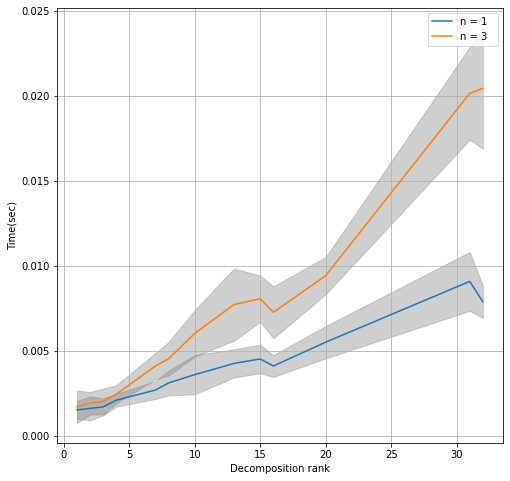

In [156]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
# for filename in ["n = 16 TT_mean_var_rank.txt", "n = 32 TT_mean_var_rank.txt",
#                  "n = 64 TT_mean_var_rank.txt", "n = 128TT_mean_var_rank.txt"]:
for filename in ["n = 1  TT_mean_var_rank.txt", "n = 3  TT_mean_var_rank.txt"]:
    means, stds = read_from_file(filename)
    ax.plot(x_axis[:means.shape[0]], means, label=filename[:7])
    ax.fill_between(x_axis[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Decomposition rank')
ax.set_ylabel('Time(sec)')
ax.grid(True)

In [143]:
import time
import functions

def tensorflow_method64_time(kernel, n, times):
    conv_tr = tf.cast(tf.transpose(kernel, perm=[2, 3, 0, 1]), tf.complex64)
    times.append(time.time())
    transforms = tf.transpose(
        tf.signal.fft2d(
            tf.pad(
                conv_tr, ((0, 0), (0, 0), (0, n - kernel.shape[0]),
                                (0, n - kernel.shape[0]))
            )
        ), 
        perm=[2, 3, 0, 1]
    )
    times.append(time.time())
#     res = tf.linalg.svd(transforms, compute_uv=False)
    res = tf.linalg.qr(transforms)
    times.append(time.time())
    return res, times

def numpy_method_time(kernel, n, times):
    times.append(time.time())
    transforms = np.fft.fft2(kernel, (n, n), axes=[0, 1])
    times.append(time.time())
    svd = np.linalg.svd(transforms, compute_uv=False)
    times.append(time.time())
    return svd, times

def TT_method_time(kernel, n, method):
    times = [time.time()]
    K1, K2, K3 = functions.Clipping.get_new_K(kernel[0], kernel[1], kernel[2])
    times.append(time.time())
    return method(K2, n, times)

In [158]:
def get_times(rank, k, n, method=tensorflow_method64_time):
    res_times = []
    test = 10
    ans = 0
    for i in range(test):
        kernel = [0] * 3
        m = 1000
        kernel[0] = np.random.standard_normal(size=(m, rank))
        kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
        kernel[2] = np.random.standard_normal(size=(rank, m))
        res, times = TT_method_time(kernel, n, method)
        times.append(time.time())
        ans += times[-1] - times[0]
        print(times[-1] - times[0])
        times_between = []
        for i in range(1, len(times)):
            times_between.append(times[i] - times[i - 1])
        if len(res_times) == 0:
            res_times = np.array(times_between)
        else:
            res_times += np.array(times_between)
    res_times /= test
    ans /= test
    print(ans)
    return res_times

In [159]:
times1 = get_times(1, 3, 64)

0.010009527206420898
0.009974002838134766
0.008977413177490234
0.009970664978027344
0.009972810745239258
0.010007858276367188
0.009969472885131836
0.007937431335449219
0.0060198307037353516
0.005941152572631836
0.008878016471862793


In [160]:
times2 = get_times(2, 3, 64)

0.01894831657409668
0.01496124267578125
0.014960527420043945
0.011001825332641602
0.03577995300292969
0.030585527420043945
0.01097559928894043
0.009652137756347656
0.009970664978027344
0.011118173599243164
0.01679539680480957


In [161]:
list(times1)

[0.0016026258468627929,
 0.0001959562301635742,
 0.0008006811141967774,
 0.0062787532806396484,
 0.0]

In [162]:
list(times2)

[0.0017003059387207032, 0.0, 0.0024336099624633787, 0.012661480903625488, 0.0]

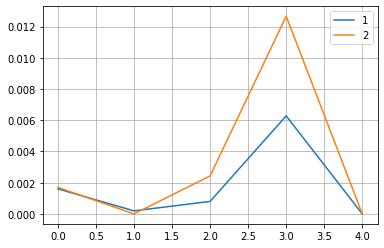

In [163]:
plt.plot(times1, label="1")
plt.plot(times2, label="2")
plt.grid(True)
plt.legend(loc='best')

In [311]:
def create_file_timestamps(filename):
    file_timestamps = open(filename, "w")
    file_timestamps.close()
    return [], []

def aggregate_results(curr_times, filename, timestamps_means, timestamps_vars):
    curr_times = np.array(curr_times)
    curr_mean = curr_times.mean()
    curr_var = curr_times.var()
    file_timestamps = open(filename, "a")
    print(curr_mean, curr_var, file=file_timestamps)
    file_timestamps.close()
    timestamps_means.append(curr_mean)
    timestamps_vars.append(curr_var)


def test_TT_method(filename, x_axis, k, n, m):
    timestamps_means, timestamps_vars = create_file_timestamps(filename)
    curr_times_baseline = []
    for rank in x_axis:
        print("Starting with", rank)
        curr_times = []
        for i in range(20):
            kernel = [0] * 3
            rank = min(m, rank)
            kernel[0] = np.random.standard_normal(size=(m, rank))
            kernel[1] = np.random.standard_normal(size=(rank, k, k, rank))
            kernel[2] = np.random.standard_normal(size=(rank, m))
            start = time.time()
            s = TT_method(kernel, n)
            total = time.time() - start
            curr_times.append(total)
            if i < 5:
                full_kernel = functions.full_tt(kernel[0], kernel[1], kernel[2])
                start = time.time()
                s = tensorflow_method64(full_kernel, n)
                total = time.time() - start
                curr_times_baseline.append(total)
            if total >= 500:
                break
#         print(curr_times)
        aggregate_results(curr_times, filename, timestamps_means, timestamps_vars)
        baseline = open("baseline_" + filename, "w")
        print(np.mean(np.array(curr_times_baseline)), file=baseline)
        baseline.close()
        print("Finishing with", rank)
        print("Mean time", timestamps_means[-1])
        if total >= 500:
            break

In [312]:
test_TT_method("n = 16 TT_mean_var_rank.txt", x_axis, k, 16, 40)

Starting with 1
Finishing with 1
Mean time 0.0020972371101379396
Starting with 2
Finishing with 2
Mean time 0.0020978450775146484
Starting with 3
Finishing with 3
Mean time 0.004155707359313965
Starting with 4
Finishing with 4
Mean time 0.005178999900817871
Starting with 7
Finishing with 7
Mean time 0.006810569763183593
Starting with 8
Finishing with 8
Mean time 0.008409571647644044
Starting with 10
Finishing with 10
Mean time 0.013667523860931396
Starting with 13
Finishing with 13
Mean time 0.029829394817352296
Starting with 15
Finishing with 15
Mean time 0.04552832841873169
Starting with 16
Finishing with 16
Mean time 0.020894062519073487
Starting with 20
Finishing with 20
Mean time 0.032064056396484374
Starting with 31
Finishing with 31
Mean time 0.05560113191604614
Starting with 32
Finishing with 32
Mean time 0.056151628494262695


In [313]:
test_TT_method("n = 32 TT_mean_var_rank.txt", x_axis, k, 32, 40)

Starting with 1
Finishing with 1
Mean time 0.0032378196716308593
Starting with 2
Finishing with 2
Mean time 0.004200637340545654
Starting with 3
Finishing with 3
Mean time 0.00609215497970581
Starting with 4
Finishing with 4
Mean time 0.007627427577972412
Starting with 7
Finishing with 7
Mean time 0.02302672863006592
Starting with 8
Finishing with 8
Mean time 0.03263009786605835
Starting with 10
Finishing with 10
Mean time 0.05854356288909912
Starting with 13
Finishing with 13
Mean time 0.10368551015853882
Starting with 15
Finishing with 15
Mean time 0.15992015600204468
Starting with 16
Finishing with 16
Mean time 0.08092323541641236
Starting with 20
Finishing with 20
Mean time 0.10910574197769166
Starting with 31
Finishing with 31
Mean time 0.2187712550163269
Starting with 32
Finishing with 32
Mean time 0.2234718084335327


In [314]:
test_TT_method("n = 64 TT_mean_var_rank.txt", x_axis, 3, 64, 40)

Starting with 1
Finishing with 1
Mean time 0.008279538154602051
Starting with 2
Finishing with 2
Mean time 0.005830633640289307
Starting with 3
Finishing with 3
Mean time 0.01601806879043579
Starting with 4
Finishing with 4
Mean time 0.023266470432281493
Starting with 7
Finishing with 7
Mean time 0.0777804970741272
Starting with 8
Finishing with 8
Mean time 0.11506549119949341
Starting with 10
Finishing with 10
Mean time 0.19134187698364258
Starting with 13
Finishing with 13
Mean time 0.37918699979782106
Starting with 15
Finishing with 15
Mean time 0.5227981209754944
Starting with 16
Finishing with 16
Mean time 0.2479744553565979
Starting with 20
Finishing with 20
Mean time 0.38919456005096437
Starting with 31
Finishing with 31
Mean time 0.9036806702613831
Starting with 32
Finishing with 32
Mean time 0.9306817531585694


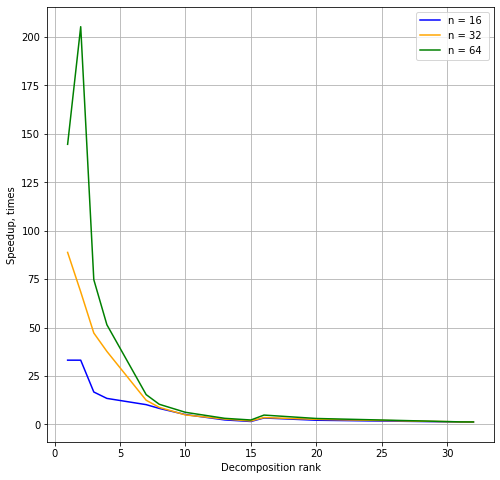

In [315]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['blue', 'orange', 'green', 'red']
# for filename in ["n = 16 TT_mean_var_rank.txt", "n = 32 TT_mean_var_rank.txt",
#                  "n = 64 TT_mean_var_rank.txt", "n = 128TT_mean_var_rank.txt"]:
filenames = ["n = 16 TT_mean_var_rank.txt", "n = 32 TT_mean_var_rank.txt",
             "n = 64 TT_mean_var_rank.txt"]
for i in range(len(filenames)):
    filename = filenames[i]
    means, stds = read_from_file(filename)
    baseline = open("baseline_" + filename)
    mean_baseline = float(baseline.read())
    baseline.close()
    ax.plot(x_axis[:means.shape[0]], mean_baseline / means, label=filename[:7], c=colors[i])
#     ax.axhline(mean_baseline, label='baseline' + filename[3:7], c=colors[i])
#     ax.fill_between(x_axis[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Decomposition rank')
ax.set_ylabel('Speedup, times')
# ax.set_ylim(0, 200)
ax.grid(True)
plt.savefig('TT_speedup.pdf', bbox_inches='tight')

In [33]:
 mean_baseline

1.238659376364488

In [34]:
 means

array([0.00847435, 0.00586998, 0.01134448, 0.02044201, 0.08425651,
       0.10771632, 0.20386155, 0.39229112, 0.5411509 , 0.25042763,
       0.38761785, 0.91850455, 0.89988182])

In [35]:
 mean_baseline / means

array([146.16570946, 211.0157786 , 109.18608171,  60.59381825,
        14.7010532 ,  11.49927285,   6.07598342,   3.15750045,
         2.28893525,   4.94617702,   3.19556846,   1.34856096,
         1.37646895])

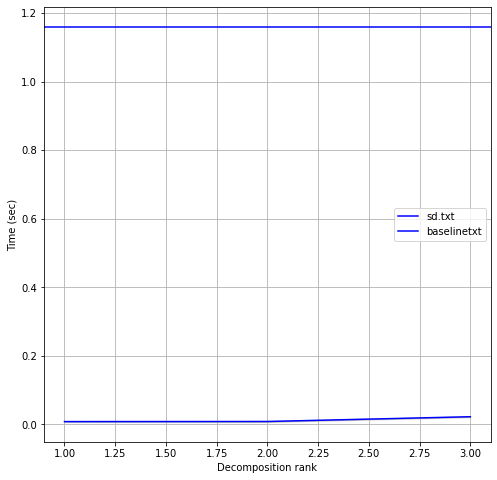

In [173]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['blue', 'orange', 'green', 'red']
# for filename in ["n = 16 TT_mean_var_rank.txt", "n = 32 TT_mean_var_rank.txt",
#                  "n = 64 TT_mean_var_rank.txt", "n = 128TT_mean_var_rank.txt"]:
filenames = ["sd.txt"]
for i in range(len(filenames)):
    filename = filenames[i]
    means, stds = read_from_file(filename)
    baseline = open("baseline_" + filename)
    mean_baseline = float(baseline.read())
    baseline.close()
    ax.plot(x_axis[:means.shape[0]], means, label=filename[:7], c=colors[i])
    ax.axhline(mean_baseline, label='baseline' + filename[3:7], c=colors[i])
    ax.fill_between(x_axis[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Decomposition rank')
ax.set_ylabel('Time (sec)')
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 0.5)
ax.grid(True)

In [209]:
x_axis2 = [1, 2, 3, 4, 7, 8, 10, 13, 15, 16, 20, 25, 31, 32]

In [221]:
import functools
from tensorflow.python.ops import nn_ops

def create_file_timestamps(filename):
    file_timestamps = open(filename, "w")
    file_timestamps.close()
    return [], []

def aggregate_results(curr_times, filename, timestamps_means, timestamps_vars):
    curr_times = np.array(curr_times)
    curr_mean = curr_times.mean()
    curr_var = curr_times.var()
    file_timestamps = open(filename, "a")
    print(curr_mean, curr_var, file=file_timestamps)
    file_timestamps.close()
    timestamps_means.append(curr_mean)
    timestamps_vars.append(curr_var)


def test_TT_method_inference(filename, x_axis, k, n, m, batch):
    f_timestamps_means, f_timestamps_vars = create_file_timestamps("faster_" + filename)
    s_timestamps_means, s_timestamps_vars = create_file_timestamps("slower_" + filename)
    for rank in x_axis:
        print("Starting with", rank)
        f_curr_times = []
        s_curr_times = []
        for i in range(100):
            inputs = tf.cast(np.random.standard_normal(size=(batch, n, n, m)), tf.float64)
            conv2d = functions.ConvDecomposed2D(m, k, rank, use_memory=True, use_memory_test=True, dtype=tf.float64)
            conv2d.build(inputs.shape)
            start = time.time()
            outputs = conv2d.call(inputs, False)
            total = time.time() - start
            f_curr_times.append(total)
            conv2d = functions.ConvDecomposed2D(m, k, rank, use_memory=False, use_memory_test=False, dtype=tf.float64)
            conv2d.build(inputs.shape)
            start = time.time()
            outputs = conv2d.call(inputs, False)
            total = time.time() - start
            s_curr_times.append(total)
            if total >= 500:
                break
        aggregate_results(f_curr_times, "faster_" + filename, f_timestamps_means, f_timestamps_vars)
        aggregate_results(s_curr_times, "slower_" + filename, s_timestamps_means, s_timestamps_vars)
        print("Finishing with", rank)
        print("Mean time", f_timestamps_means[-1], s_timestamps_means[-1])
        if total >= 500:
            break

In [210]:
test_TT_method_inference("n = 16, m = 40, batch = 128, TT_mean_var_inference.txt", x_axis2, 3, 16, 40, 128)

Starting with 1
Finishing with 1
Mean time 0.024432897567749023 0.01673712730407715
Starting with 2
Finishing with 2
Mean time 0.024618542194366454 0.01579240560531616
Starting with 3
Finishing with 3
Mean time 0.02433115243911743 0.014865505695343017
Starting with 4
Finishing with 4
Mean time 0.023178064823150636 0.014644861221313477
Starting with 7
Finishing with 7
Mean time 0.023684942722320558 0.016725873947143553
Starting with 8
Finishing with 8
Mean time 0.024761712551116942 0.012553524971008301
Starting with 10
Finishing with 10
Mean time 0.0241959810256958 0.01815730333328247
Starting with 13
Finishing with 13
Mean time 0.027184438705444337 0.024283063411712647
Starting with 15
Finishing with 15
Mean time 0.02397688627243042 0.02467612028121948
Starting with 16
Finishing with 16
Mean time 0.024978244304656984 0.01704362630844116
Starting with 20
Finishing with 20
Mean time 0.023280394077301026 0.01818631887435913
Starting with 25
Finishing with 25
Mean time 0.024484729766845702

In [211]:
test_TT_method_inference("n = 16, m = 32, batch = 128, TT_mean_var_inference.txt", x_axis2, 3, 16, 40, 128)

Starting with 1
Finishing with 1
Mean time 0.025330615043640137 0.01959284543991089
Starting with 2
Finishing with 2
Mean time 0.02347543239593506 0.015291345119476319
Starting with 3
Finishing with 3
Mean time 0.023703205585479736 0.01391773223876953
Starting with 4
Finishing with 4
Mean time 0.023084163665771484 0.014457666873931884
Starting with 7
Finishing with 7
Mean time 0.023282206058502196 0.01675194501876831
Starting with 8
Finishing with 8
Mean time 0.023234057426452636 0.011853265762329101
Starting with 10
Finishing with 10
Mean time 0.022831153869628907 0.01739727258682251
Starting with 13
Finishing with 13
Mean time 0.023233020305633546 0.020747363567352295
Starting with 15
Finishing with 15
Mean time 0.022773003578186034 0.0235537052154541
Starting with 16
Finishing with 16
Mean time 0.023729562759399414 0.016233134269714355
Starting with 20
Finishing with 20
Mean time 0.023935151100158692 0.01799880266189575
Starting with 25
Finishing with 25
Mean time 0.0234753608703613

In [222]:
test_TT_method_inference("n = 16, m = 40, batch = 16, TT_mean_var_inference.txt", x_axis2, 3, 16, 40, 16)

Starting with 1
Finishing with 1
Mean time 0.004276888370513916 0.003605217933654785
Starting with 2
Finishing with 2
Mean time 0.004509510993957519 0.003571102619171143
Starting with 3
Finishing with 3
Mean time 0.004293212890625 0.003299274444580078
Starting with 4
Finishing with 4
Mean time 0.004243662357330322 0.0030518412590026856
Starting with 7
Finishing with 7
Mean time 0.00478435754776001 0.00446892261505127
Starting with 8
Finishing with 8
Mean time 0.004327495098114014 0.003689460754394531
Starting with 10
Finishing with 10
Mean time 0.004245750904083252 0.004056117534637451
Starting with 13
Finishing with 13
Mean time 0.004225757122039795 0.00504382848739624
Starting with 15
Finishing with 15
Mean time 0.00437685489654541 0.005628712177276611
Starting with 16
Finishing with 16
Mean time 0.004474337100982666 0.0036682677268981933
Starting with 20
Finishing with 20
Mean time 0.004089043140411377 0.003719756603240967
Starting with 25
Finishing with 25
Mean time 0.0043892669677

In [224]:
test_TT_method_inference("n = 16, m = 40, batch = 1, TT_mean_var_inference.txt", x_axis2, 3, 16, 40, 1)

Starting with 1
Finishing with 1
Mean time 0.002043042182922363 0.0013671350479125977
Starting with 2
Finishing with 2
Mean time 0.0024945664405822752 0.0014951634407043457
Starting with 3
Finishing with 3
Mean time 0.0017980337142944336 0.001186819076538086
Starting with 4
Finishing with 4
Mean time 0.002258636951446533 0.001347200870513916
Starting with 7
Finishing with 7
Mean time 0.0019828414916992186 0.0014458584785461426
Starting with 8
Finishing with 8
Mean time 0.0018654179573059082 0.0013428092002868651
Starting with 10
Finishing with 10
Mean time 0.002126421928405762 0.0016747140884399415
Starting with 13
Finishing with 13
Mean time 0.0020228719711303713 0.0016318273544311524
Starting with 15
Finishing with 15
Mean time 0.0019629740715026854 0.001750791072845459
Starting with 16
Finishing with 16
Mean time 0.0022658586502075197 0.0015662240982055665
Starting with 20
Finishing with 20
Mean time 0.002152986526489258 0.0015909528732299804
Starting with 25
Finishing with 25
Mean 

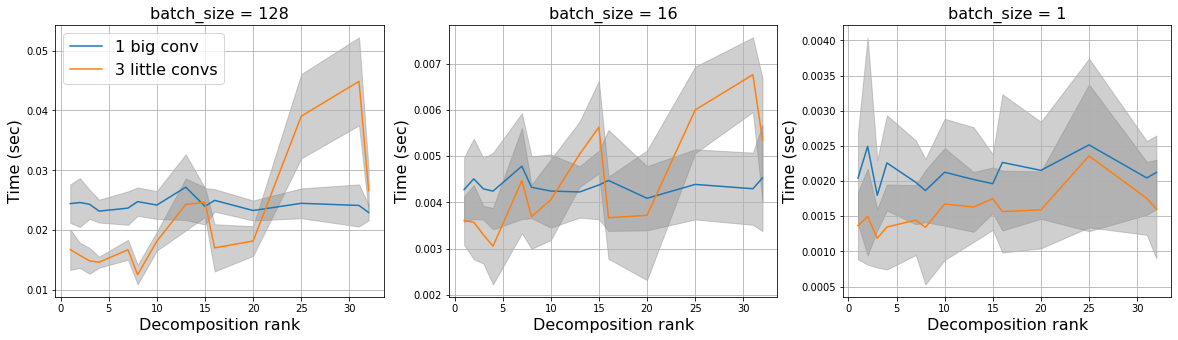

In [332]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
colors = ['batch_size = 128', 'batch_size = 16', 'batch_size = 1']
# for filename in ["n = 16 TT_mean_var_rank.txt", "n = 32 TT_mean_var_rank.txt",
#                  "n = 64 TT_mean_var_rank.txt", "n = 128TT_mean_var_rank.txt"]:
filenames = ["n = 16, m = 40, TT_mean_var_inference.txt", "n = 16, m = 40, batch = 16, TT_mean_var_inference.txt",
             "n = 16, m = 40, batch = 1, TT_mean_var_inference.txt"]
for i in range(len(filenames)):
    filename = filenames[i]
    means, stds = read_from_file("faster_" + filename)
    ax[i].plot(x_axis2[:means.shape[0]], means, label="1 big conv")
    ax[i].fill_between(x_axis2[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
    means, stds = read_from_file("slower_" + filename)
    ax[i].plot(x_axis2[:means.shape[0]], means, label="3 little convs")
    ax[i].fill_between(x_axis2[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
    ax[i].set_xlabel('Decomposition rank', fontsize=16)
    ax[i].set_ylabel('Time (sec)', fontsize=16)
    # ax.set_xlim(0, 5)
    # ax.set_ylim(0, 0.5)
    ax[i].grid(True)
    ax[i].set_title(colors[i], fontsize=16)
ax[0].legend(loc='upper left', fontsize=16)

plt.savefig('TT_convs.pdf', bbox_inches='tight')

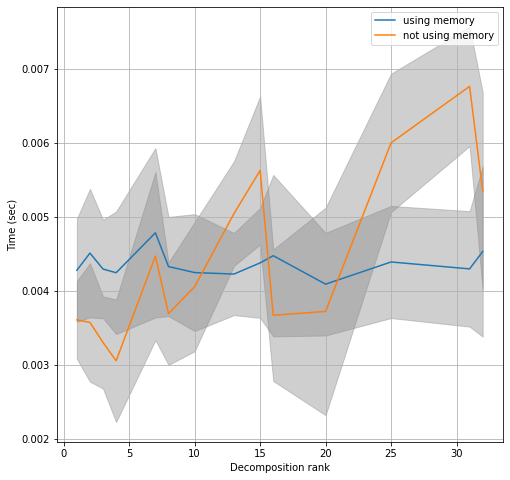

In [223]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['blue', 'orange', 'green', 'red']
# for filename in ["n = 16 TT_mean_var_rank.txt", "n = 32 TT_mean_var_rank.txt",
#                  "n = 64 TT_mean_var_rank.txt", "n = 128TT_mean_var_rank.txt"]:
filenames = ["n = 16, m = 40, batch = 16, TT_mean_var_inference.txt"]
for i in range(len(filenames)):
    filename = filenames[i]
    means, stds = read_from_file("faster_" + filename)
    ax.plot(x_axis2[:means.shape[0]], means, label="using memory")
    ax.fill_between(x_axis2[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
    means, stds = read_from_file("slower_" + filename)
    ax.plot(x_axis2[:means.shape[0]], means, label="not using memory")
    ax.fill_between(x_axis2[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Decomposition rank')
ax.set_ylabel('Time (sec)')
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 0.5)
ax.grid(True)

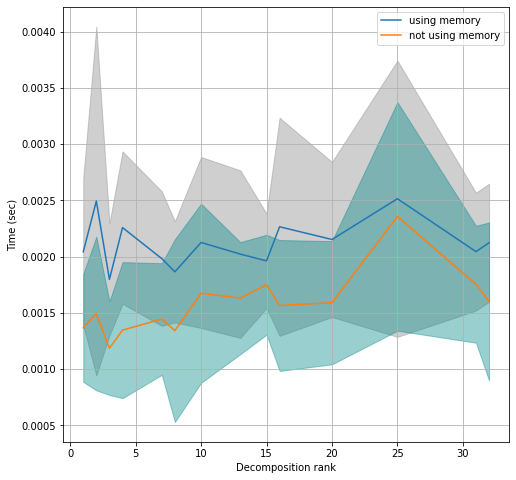

In [316]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
colors = ['blue', 'orange', 'green', 'red']
# for filename in ["n = 16 TT_mean_var_rank.txt", "n = 32 TT_mean_var_rank.txt",
#                  "n = 64 TT_mean_var_rank.txt", "n = 128TT_mean_var_rank.txt"]:
filenames = ["n = 16, m = 40, batch = 1, TT_mean_var_inference.txt"]
for i in range(len(filenames)):
    filename = filenames[i]
    means, stds = read_from_file("faster_" + filename)
    ax.plot(x_axis2[:means.shape[0]], means, label="using memory")
    ax.fill_between(x_axis2[:means.shape[0]], means + stds, means - stds, color='#888888', alpha=0.4)
    means, stds = read_from_file("slower_" + filename)
    ax.plot(x_axis2[:means.shape[0]], means, label="not using memory")
    ax.fill_between(x_axis2[:means.shape[0]], means + stds, means - stds, color='#008888', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Decomposition rank')
ax.set_ylabel('Time (sec)')
# ax.set_xlim(0, 5)
# ax.set_ylim(0, 0.5)
ax.grid(True)

In [258]:
def slower_without_memory_time(convolution_op, inputs, K1, K2, K3):
    times = []
    start = time.time()
    inputs1 = convolution_op(inputs, tf.reshape(K1, (1, 1, K1.shape[0], K1.shape[1])))
    times.append(time.time() - start)
    start = time.time()
    inputs2 = convolution_op(inputs1, tf.transpose(K2, perm=[1, 2, 0, 3]))
    times.append(time.time() - start)
    start = time.time()
    res = convolution_op(inputs2, tf.reshape(K3, (1, 1, K3.shape[0], K3.shape[1])))
    times.append(time.time() - start)
    return res, times

def faster_memory_time(convolution_op, inputs, K1, K2, K3):
    times = []
    start = time.time()
    full_kernel = full_tt(K1, K2, K3)
    times.append(time.time() - start)
    start = time.time()
    res = convolution_op(inputs, full_kernel)
    times.append(time.time() - start)
    return res, times

def times_conv2d(rank):
    batch = 128
    n = 16
    m = 40
    k = 3
    test = 10
    res = np.zeros(3)
    for i in range(test):
        inputs = tf.cast(np.random.standard_normal(size=(batch, n, n, m)), tf.float64)
        conv2d = functions.ConvDecomposed2D(m, k, rank, use_memory=False, use_memory_test=False, dtype=tf.float64)
        conv2d.build(inputs.shape)
        outputs, times = slower_without_memory_time(conv2d._convolution_op, inputs, conv2d.K1, conv2d.K2, conv2d.K3)
        res += times
    res /= test
    return res

In [241]:
times15 = times_conv2d(15)

In [242]:
times16 = times_conv2d(16)

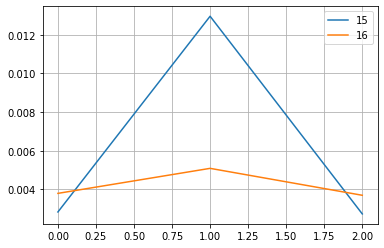

In [243]:
plt.plot(times15, label="15")
plt.plot(times16, label="16")
plt.grid(True)
plt.legend(loc='best')

In [255]:
batch = 128
n = 16
m = 40
k = 3
rank = 15
inputs = tf.cast(np.random.standard_normal(size=(batch, n, n, m)), tf.float64)
conv2d = functions.ConvDecomposed2D(m, k, rank, use_memory=True, use_memory_test=True, dtype=tf.float64)
conv2d.build(inputs.shape)
outputs = faster_memory_time(conv2d._convolution_op, inputs, conv2d.K1, conv2d.K2, conv2d.K3)

0.016954898834228516 (3, 3, 40, 40)


In [256]:
batch = 128
n = 16
m = 15
k = 3
rank = 15
inputs = tf.cast(np.random.standard_normal(size=(batch, n, n, m)), tf.float64)
conv2d = functions.ConvDecomposed2D(m, k, rank, use_memory=True, use_memory_test=True, dtype=tf.float64)
conv2d.build(inputs.shape)
outputs = faster_memory_time(conv2d._convolution_op, inputs, conv2d.K1, conv2d.K2, conv2d.K3)

0.011964797973632812 (3, 3, 15, 15)


In [278]:
import functools
from tensorflow.python.ops import nn_ops
import pickle

def create_file_timestamps(filename):
    file_timestamps = open(filename, "w")
    file_timestamps.close()
    return [], []

def aggregate_results(curr_times, filename, timestamps_means, timestamps_vars):
    curr_times = np.array(curr_times)
    curr_mean = curr_times.mean()
    curr_var = curr_times.var()
    file_timestamps = open(filename, "a")
    print(curr_mean, curr_var, file=file_timestamps)
    file_timestamps.close()
    timestamps_means.append(curr_mean)
    timestamps_vars.append(curr_var)


def test_TT_method_inference_times(filename, x_axis, k, n, m, batch):
    f_timestamps_means, f_timestamps_vars = create_file_timestamps("faster_" + filename)
    s_timestamps_means, s_timestamps_vars = create_file_timestamps("slower_" + filename)
    f_times = np.zeros((len(x_axis), 2))
    s_times = np.zeros((len(x_axis), 3))
    ind = 0
    test = 10
    for rank in x_axis:
        print("Starting with", rank)
        f_curr_times = []
        s_curr_times = []
        for i in range(test):
            inputs = tf.cast(np.random.standard_normal(size=(batch, n, n, m)), tf.float64)
            conv2d = functions.ConvDecomposed2D(m, k, rank, use_memory=True, use_memory_test=True, dtype=tf.float64)
            conv2d.build(inputs.shape)
            start = time.time()
            outputs, times = faster_memory_time(conv2d._convolution_op, inputs, conv2d.K1, conv2d.K2, conv2d.K3)
            total = time.time() - start
            f_curr_times.append(total)
            f_times[ind, :] += np.array(times)
            conv2d = functions.ConvDecomposed2D(m, k, rank, use_memory=False, use_memory_test=False, dtype=tf.float64)
            conv2d.build(inputs.shape)
            start = time.time()
            outputs, times = slower_without_memory_time(conv2d._convolution_op, inputs, conv2d.K1,
                                                        conv2d.K2, conv2d.K3)
            total = time.time() - start
            s_curr_times.append(total)
            s_times[ind, :] += np.array(times)
            if total >= 500:
                break
        aggregate_results(f_curr_times, "faster_" + filename, f_timestamps_means, f_timestamps_vars)
        aggregate_results(s_curr_times, "slower_" + filename, s_timestamps_means, s_timestamps_vars)
        f_times[ind] /= test
        s_times[ind] /= test
        print("Finishing with", rank)
        print("Mean time", f_timestamps_means[-1], s_timestamps_means[-1])
        if total >= 500:
            break
        ind += 1
    with open("faster_info_" + filename, 'wb') as fp:
        pickle.dump(f_times, fp)
    with open("slower_info_" + filename, 'wb') as fp:
        pickle.dump(s_times, fp)

In [279]:
test_TT_method_inference_times("n = 16, m = 40, batch = 128, TT_mean_var_inference.txt", x_axis2, 3, 16, 40, 128)

Starting with 1
Finishing with 1
Mean time 0.019436073303222657 0.010865211486816406
Starting with 2
Finishing with 2
Mean time 0.020841479301452637 0.013966202735900879
Starting with 3
Finishing with 3
Mean time 0.019043803215026855 0.009764885902404786
Starting with 4
Finishing with 4
Mean time 0.019933533668518067 0.011277294158935547
Starting with 7
Finishing with 7
Mean time 0.019130873680114745 0.012946867942810058
Starting with 8
Finishing with 8
Mean time 0.02012031078338623 0.008397722244262695
Starting with 10
Finishing with 10
Mean time 0.020334935188293456 0.014461398124694824
Starting with 13
Finishing with 13
Mean time 0.01823592185974121 0.016410231590270996
Starting with 15
Finishing with 15
Mean time 0.020339179039001464 0.019660186767578126
Starting with 16
Finishing with 16
Mean time 0.019225096702575682 0.010987567901611327
Starting with 20
Finishing with 20
Mean time 0.019834017753601073 0.014222931861877442
Starting with 25
Finishing with 25
Mean time 0.0207401990

In [335]:
filename = "n = 16, m = 40, batch = 128, TT_mean_var_inference.txt"
with open("faster_info_" + filename, 'rb') as fp:
    f_times = pickle.load(fp)
with open("slower_info_" + filename, 'rb') as fp:
    s_times = pickle.load(fp)

In [336]:
f_times

array([[0.00110178, 0.01742527],
       [0.00089777, 0.01814415],
       [0.00070109, 0.01724052],
       [0.00100091, 0.01793456],
       [0.00099623, 0.0170294 ],
       [0.00109479, 0.01792383],
       [0.0010978 , 0.01823936],
       [0.00100121, 0.01643286],
       [0.00100346, 0.01813133],
       [0.00099692, 0.01732616],
       [0.00099688, 0.01773202],
       [0.00139575, 0.01824391],
       [0.00100033, 0.01713302],
       [0.00109425, 0.0171397 ]])

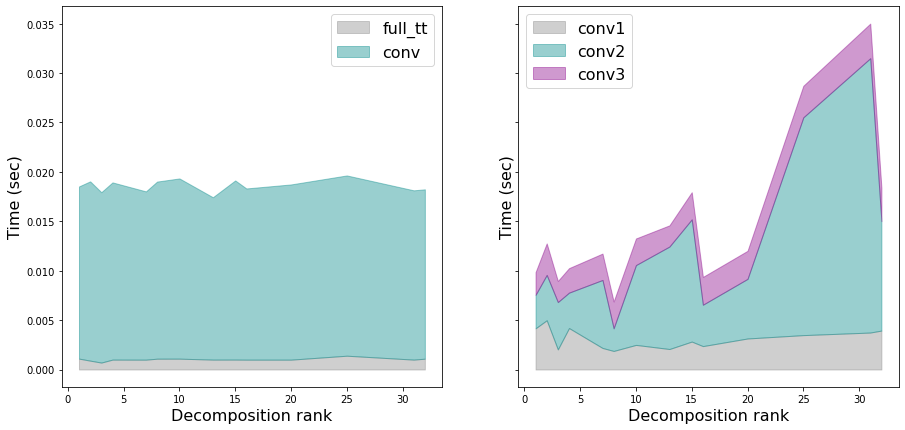

In [337]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axes[0].fill_between(x_axis2, 0, f_times[:, 0], color='#888888', alpha=0.4, label="full_tt")
axes[0].fill_between(x_axis2, f_times[:, 0], f_times[:, 0] + f_times[:, 1], color='#008888', alpha=0.4, label='conv')
axes[1].fill_between(x_axis2, 0, s_times[:, 0], color='#888888', alpha=0.4, label='conv1')
axes[1].fill_between(x_axis2, s_times[:, 0], s_times[:, 0] + s_times[:, 1], color='#008888', alpha=0.4, label='conv2')
axes[1].fill_between(x_axis2, s_times[:, 0] + s_times[:, 1], s_times[:, 0] + s_times[:, 1] + s_times[:, 2],
                     color='#880088', alpha=0.4, label='conv3')
axes[0].legend(loc='best', fontsize=16)
axes[1].legend(loc='upper left', fontsize=16)
axes[0].set_xlabel("Decomposition rank", fontsize=16)
axes[1].set_xlabel("Decomposition rank", fontsize=16)
axes[0].set_ylabel("Time (sec)", fontsize=16)
axes[1].set_ylabel("Time (sec)", fontsize=16)

plt.savefig('TT_inside.pdf', bbox_inches='tight')

In [299]:
test_TT_method_inference_times("n = 16, m = 20, batch = 128, TT_mean_var_inference.txt", x_axis2, 3, 16, 20, 128)

Starting with 1
Finishing with 1
Mean time 0.00706634521484375 0.0076563358306884766
Starting with 2
Finishing with 2
Mean time 0.008799338340759277 0.012256288528442382
Starting with 3
Finishing with 3
Mean time 0.008565521240234375 0.014011096954345704
Starting with 4
Finishing with 4
Mean time 0.007597970962524414 0.008762454986572266
Starting with 7
Finishing with 7
Mean time 0.010539984703063965 0.01680622100830078
Starting with 8
Finishing with 8
Mean time 0.007162141799926758 0.009865260124206543
Starting with 10
Finishing with 10
Mean time 0.008759760856628418 0.015030336380004884
Starting with 13
Finishing with 13
Mean time 0.009057855606079102 0.01894981861114502
Starting with 15
Finishing with 15
Mean time 0.00897204875946045 0.02263967990875244
Starting with 16
Finishing with 16
Mean time 0.009774303436279297 0.01346418857574463
Starting with 20
Finishing with 20
Mean time 0.00754694938659668 0.013095736503601074
Starting with 25
Finishing with 25
Mean time 0.00729217529296

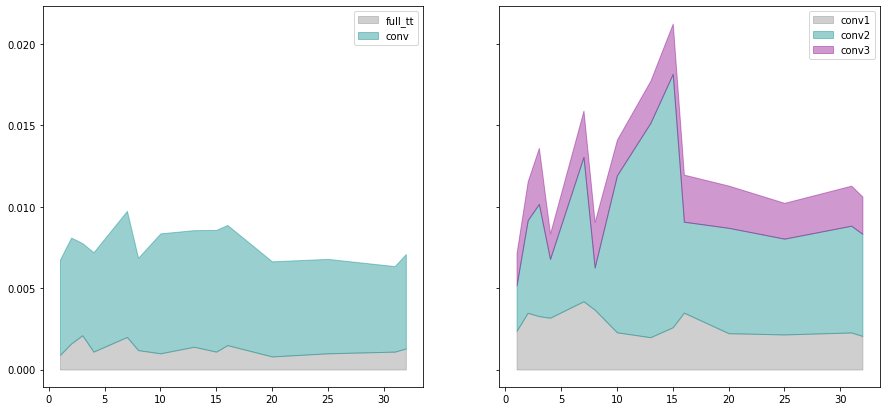

In [305]:
filename = "n = 16, m = 20, batch = 128, TT_mean_var_inference.txt"
with open("faster_info_" + filename, 'rb') as fp:
    f_times = pickle.load(fp)
with open("slower_info_" + filename, 'rb') as fp:
    s_times = pickle.load(fp)
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axes[0].fill_between(x_axis2, 0, f_times[:, 0], color='#888888', alpha=0.4, label="full_tt")
axes[0].fill_between(x_axis2, f_times[:, 0], f_times[:, 0] + f_times[:, 1], color='#008888', alpha=0.4, label='conv')
axes[1].fill_between(x_axis2, 0, s_times[:, 0], color='#888888', alpha=0.4, label='conv1')
axes[1].fill_between(x_axis2, s_times[:, 0], s_times[:, 0] + s_times[:, 1], color='#008888', alpha=0.4, label='conv2')
axes[1].fill_between(x_axis2, s_times[:, 0] + s_times[:, 1], s_times[:, 0] + s_times[:, 1] + s_times[:, 2],
                     color='#880088', alpha=0.4, label='conv3')
axes[0].legend(loc='best')
axes[1].legend(loc='best')

In [306]:
test_TT_method_inference_times("n = 16, m = 15, batch = 128, TT_mean_var_inference.txt", x_axis2, 3, 16, 15, 128)

Starting with 1
Finishing with 1
Mean time 0.013231682777404784 0.006771445274353027
Starting with 2
Finishing with 2
Mean time 0.013343405723571778 0.007666254043579101
Starting with 3
Finishing with 3
Mean time 0.01539285182952881 0.009085512161254883
Starting with 4
Finishing with 4
Mean time 0.014350628852844239 0.007670259475708008
Starting with 7
Finishing with 7
Mean time 0.015853619575500487 0.01276228427886963
Starting with 8
Finishing with 8
Mean time 0.014054632186889649 0.0069885730743408205
Starting with 10
Finishing with 10
Mean time 0.012856006622314453 0.01201193332672119
Starting with 13
Finishing with 13
Mean time 0.013142919540405274 0.015061020851135254
Starting with 15
Finishing with 15
Mean time 0.01333944797515869 0.0171539306640625
Starting with 16
Finishing with 16
Mean time 0.013054847717285156 0.017227649688720703
Starting with 20
Finishing with 20
Mean time 0.012748003005981445 0.01695117950439453
Starting with 25
Finishing with 25
Mean time 0.01342866420745

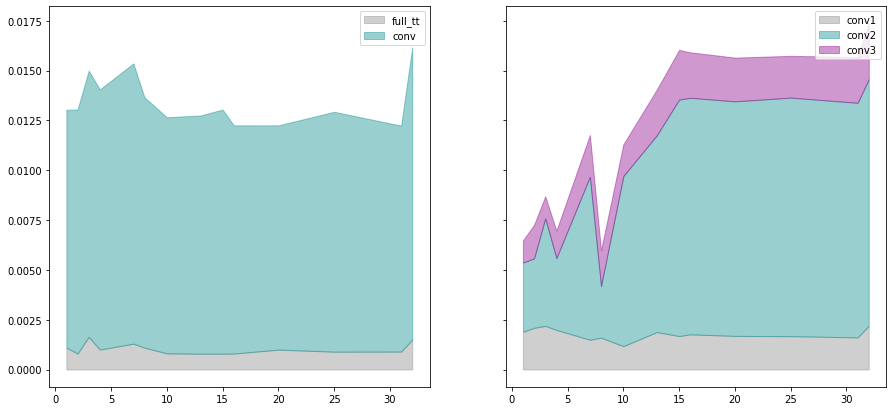

In [307]:
filename = "n = 16, m = 15, batch = 128, TT_mean_var_inference.txt"
with open("faster_info_" + filename, 'rb') as fp:
    f_times = pickle.load(fp)
with open("slower_info_" + filename, 'rb') as fp:
    s_times = pickle.load(fp)
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axes[0].fill_between(x_axis2, 0, f_times[:, 0], color='#888888', alpha=0.4, label="full_tt")
axes[0].fill_between(x_axis2, f_times[:, 0], f_times[:, 0] + f_times[:, 1], color='#008888', alpha=0.4, label='conv')
axes[1].fill_between(x_axis2, 0, s_times[:, 0], color='#888888', alpha=0.4, label='conv1')
axes[1].fill_between(x_axis2, s_times[:, 0], s_times[:, 0] + s_times[:, 1], color='#008888', alpha=0.4, label='conv2')
axes[1].fill_between(x_axis2, s_times[:, 0] + s_times[:, 1], s_times[:, 0] + s_times[:, 1] + s_times[:, 2],
                     color='#880088', alpha=0.4, label='conv3')
axes[0].legend(loc='best')
axes[1].legend(loc='best')